In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
%matplotlib inline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor


In [2]:
housing = fetch_california_housing(as_frame=True)
df = housing.frame
df.head()
X = df.drop("MedHouseVal", axis=1)
y = df["MedHouseVal"]
# Feature Scaling (Task-2 requirement)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [3]:
df.info()
df.describe()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   MedInc       20640 non-null  float64
 1   HouseAge     20640 non-null  float64
 2   AveRooms     20640 non-null  float64
 3   AveBedrms    20640 non-null  float64
 4   Population   20640 non-null  float64
 5   AveOccup     20640 non-null  float64
 6   Latitude     20640 non-null  float64
 7   Longitude    20640 non-null  float64
 8   MedHouseVal  20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


MedInc         0
HouseAge       0
AveRooms       0
AveBedrms      0
Population     0
AveOccup       0
Latitude       0
Longitude      0
MedHouseVal    0
dtype: int64

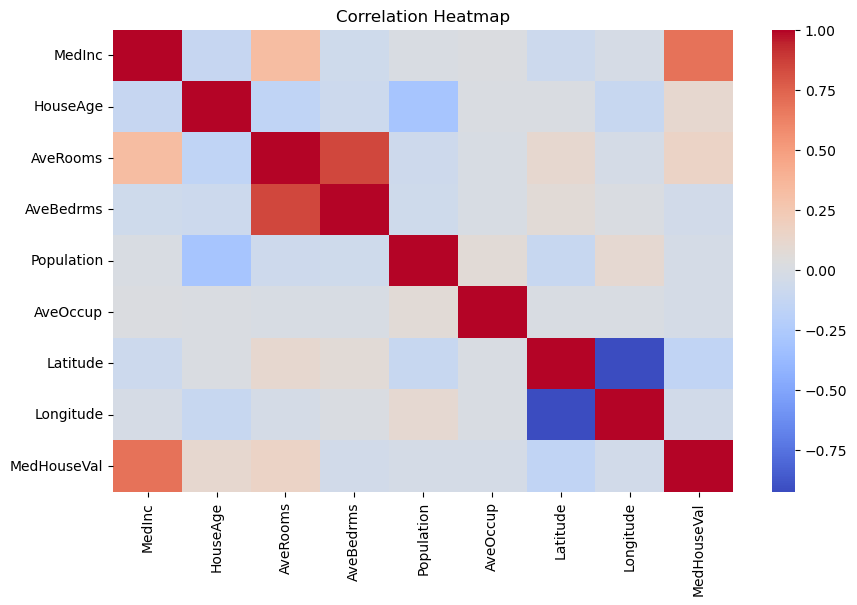

In [4]:
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(), cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

In [5]:
X = df.drop("MedHouseVal", axis=1)
y = df["MedHouseVal"]

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)


In [6]:
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(alpha=1.0),
    "Decision Tree": DecisionTreeRegressor(max_depth=5, random_state=42)
}

results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)

    rmse = np.sqrt(mean_squared_error(y_test, predictions))

    r2 = r2_score(y_test, predictions)

    results[name] = {"RMSE": rmse, "R2 Score": r2}

results_df = pd.DataFrame(results).T
print(results_df)


                       RMSE  R2 Score
Linear Regression  0.745581  0.575788
Ridge Regression   0.745554  0.575819
Decision Tree      0.724234  0.599732


In [7]:

best_model_name = results_df["R2 Score"].idxmax()
print("Best Model:", best_model_name)

best_model = models[best_model_name]
y_pred = best_model.predict(X_test)


Best Model: Decision Tree


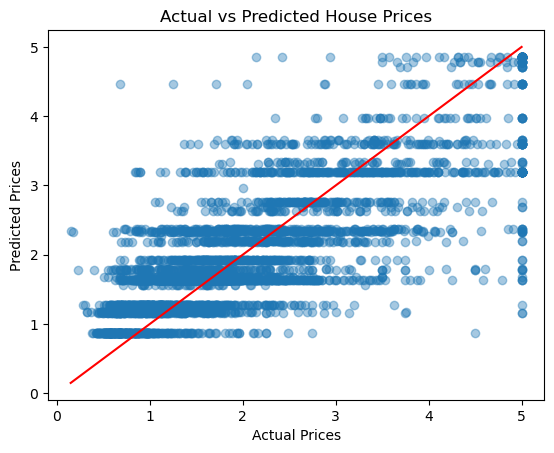

In [8]:
plt.scatter(y_test, y_pred, alpha=0.4)
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title("Actual vs Predicted House Prices")
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         color="red")
plt.show()

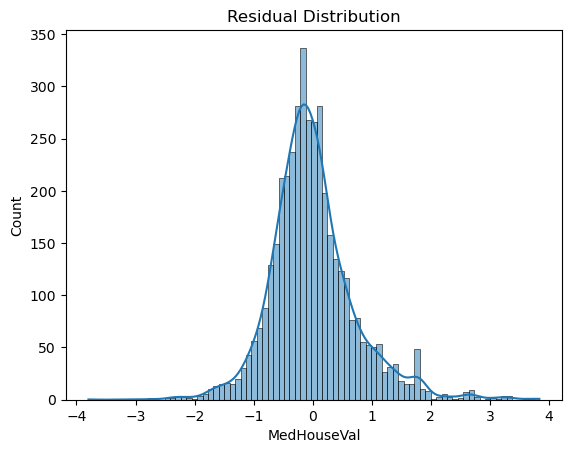

In [9]:
residuals = y_test - y_pred

sns.histplot(residuals, kde=True)
plt.title("Residual Distribution")
plt.show()


In [10]:
# Overfitting detection using Decision Tree
tree = DecisionTreeRegressor(random_state=42)
tree.fit(X_train, y_train)

train_pred = tree.predict(X_train)
test_pred = tree.predict(X_test)

train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))

print("Train RMSE:", train_rmse)
print("Test RMSE:", test_rmse)


Train RMSE: 3.218325866275131e-16
Test RMSE: 0.7030445773467542


In [11]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(
    tree, X_scaled, y,
    scoring="neg_root_mean_squared_error",
    cv=5
)

cv_rmse = -cv_scores.mean()
print("Cross Validation RMSE:", cv_rmse)


Cross Validation RMSE: 0.8957031908951016


In [12]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    "max_depth": [3,5,7,10],
    "min_samples_split": [2,5,10]
}

grid = GridSearchCV(
    DecisionTreeRegressor(random_state=42),
    param_grid,
    scoring="neg_root_mean_squared_error",
    cv=5
)

grid.fit(X_train, y_train)

print("Best Parameters:", grid.best_params_)


Best Parameters: {'max_depth': 10, 'min_samples_split': 10}


In [13]:
best_tree = grid.best_estimator_

y_pred_tuned = best_tree.predict(X_test)

rmse_tuned = np.sqrt(mean_squared_error(y_test, y_pred_tuned))
r2_tuned = r2_score(y_test, y_pred_tuned)

print("Tuned RMSE:", rmse_tuned)
print("Tuned R2:", r2_tuned)


Tuned RMSE: 0.6454300828015771
Tuned R2: 0.6820992539714815


In [14]:
final_results = pd.DataFrame({
    "Model": ["Linear Regression", "Ridge Regression", "Original Decision Tree", "Tuned Decision Tree"],
    "RMSE": [
        results_df.loc["Linear Regression","RMSE"],
        results_df.loc["Ridge Regression","RMSE"],
        results_df.loc["Decision Tree","RMSE"],
        rmse_tuned
    ],
    "R2 Score": [
        results_df.loc["Linear Regression","R2 Score"],
        results_df.loc["Ridge Regression","R2 Score"],
        results_df.loc["Decision Tree","R2 Score"],
        r2_tuned
    ]
})

final_results


,Model,RMSE,R2 Score
0,Linear Regression,0.745581,0.575788
1,Ridge Regression,0.745554,0.575819
2,Original Decision Tree,0.724234,0.599732
3,Tuned Decision Tree,0.645430,0.682099
